<h1>Introduction</h1>

<p>This Colab notebook implements a <strong>decoder-only Transformer model</strong> for predicting <strong>Bernstein polynomial values</strong> from sequential data.
The main goal is to learn a mapping from past polynomial coefficients to the next time-step polynomial, effectively modeling temporal dynamics of degree-31 polynomials.</p>

<h2>Inputs</h2>
<ul>
  <li>CSV files containing rows of Bernstein polynomial coefficients at each time step.</li>
  <li>Sequences are divided into chunks of 49 consecutive steps, forming input tensors of shape <strong>(batch_size, seq_len=48, num_features=32)</strong>.</li>
  <li>Input coefficients are converted into polynomial values over a fixed grid of 100 points using <strong>float64</strong> precision to maintain numerical accuracy.</li>
</ul>

<h2>Model Architecture</h2>
<ul>
  <li>Core model is a <strong>decoder-only Transformer</strong> with:
    <ul>
      <li>Linear projection of input polynomial values (token embedding).</li>
      <li>Positional encoding to capture sequential information.</li>
      <li>Multiple Transformer blocks with <strong>multi-head self-attention</strong>, <strong>layer normalization</strong>, and a <strong>feedforward MLP</strong>.</li>
      <li>Linear output layer predicting polynomial values over the grid.</li>
    </ul>
  </li>
  <li>Supports causal masking to ensure attention only considers past timesteps during training.</li>
</ul>

<h2>Outputs</h2>
<ul>
  <li>The model predicts the <strong>full polynomial values</strong> on the predefined grid rather than the raw coefficients, enabling functional comparison with the target polynomial.</li>
</ul>

<h2>Loss Functions and Training Philosophy</h2>
<ul>
  <li>Training emphasizes <strong>functional similarity</strong> between predicted and true polynomials, not just pointwise differences.</li>
  <li>Uses a <strong>Sobolev-inspired distance</strong> to capture both value and derivative-level discrepancies.</li>
  <li>Alternative losses like projection-based distance and Gaussian NLL are implemented for experimentation.</li>
  <li>For more detailed explanations, see the <strong>METHODS.md</strong>.</li>
</ul>

<h2>Computational Details</h2>
<ul>
  <li>GPU acceleration is enabled if available.</li>
  <li>Mixed-precision training is applied using <strong>torch.cuda.amp</strong>.</li>
  <li>Compatible with <strong>Google Colab</strong> and local execution.</li>
  <li>Experiments and hyperparameters are logged using <strong>Comet ML</strong> for reproducibility and analysis.</li>
</ul>

<h2>Summary</h2>
<p>This notebook provides a robust framework for <strong>sequence-to-polynomial prediction</strong> using Transformers and Sobolev-inspired metrics. It is designed for researchers and practitioners familiar with PyTorch, Transformers, and numerical polynomial representations.</p>

<p>For complete details, please refer to the <strong>METHODS.md</strong>.</p>


Install dependencies

Check for Google Colab or local environment

In [63]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

isColab = is_colab()

Google Colab execution only

In [65]:
if isColab:
    from IPython import get_ipython
    get_ipython().system("pip install comet_ml > /dev/null 2>&1")

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import math
import comet_ml
from comet_ml import Experiment
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm
import logging
logging.getLogger("comet_ml").setLevel(logging.WARNING)





Computational tools <br>
These tools are used to compute the loss. I prefer to use the Sobolev inner product with its induced norm and distance. Indeed, in the vector space of R-valued functions, this norm is equivalent to the usual 𝐿² norm. However, with the Sobolev inner product, we can include derivatives to capture variational similarities, not just pointwise similarities.

In [67]:
def dotProduct(y, z):
    dx = 1.0 / (y.shape[-1] - 1)
    return torch.trapz((y * z), dx=dx, dim=-1)

def normVect(v):
    return torch.sqrt(dotProduct(v, v))

def distance(y_dest, y_ref):
    diff = y_ref - y_dest
    nd = normVect(diff)
    return torch.sqrt((nd ** 2) + 1e-8)

def getProj(y_dest, y_ref):
    dp = dotProduct(y_ref, y_dest)
    normYref2 = dotProduct(y_ref, y_ref)
    return dp / (normYref2+ 1e-4)

def distanceProj(y_dest, y_ref):
    k = torch.abs(getProj(y_dest, y_ref)).unsqueeze(-1)
    diff = y_dest - (k * y_ref)
    dist = normVect(diff)/(normVect(y_dest) + 1e-4)
    return dist, k

Transform coefficient tensor into a polynomial <br>
We use dtype=torch.float64 because the coefficients represent Bernstein polynomials. When evaluating these polynomials, lower-precision types (e.g., float32) result in significant numerical errors, causing a large discrepancy between the input and output polynomials. Using float64 ensures sufficient precision for accurate computations.

In [69]:
x = torch.linspace(0, 1, 100, dtype=torch.float64)

def eval_poly(coeffs, x):
    device = coeffs.device
    B, T, D = coeffs.shape
    powers = torch.arange(D, dtype=torch.float64, device=coeffs.device).view(1,1,1,D)
    powers = powers.to(device)
    x = x.to(device)


    N = x.shape[0]

    coeffs = coeffs.view(B, T, 1, D)
    x = x.view(1, 1, N, 1)

    return torch.sum(coeffs * (x ** powers), dim=-1)




In [68]:
COMET_API_KEY = ""
if isColab:
  from google.colab import userdata
  COMET_API_KEY = userdata.get('COMET_API_KEY')
else:
  from dotenv import load_dotenv
  load_dotenv()
  COMET_API_KEY = os.getenv("COMET_API_KEY")

assert COMET_API_KEY != "", "Please insert your Comet API Key"

# Set GPU for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
learning_rate = 1e-4

# Number of epochs for training
nepochs = 5

# Batch size for data loaders
batch_size = 16

dataset = []


cpu


Import files

In [70]:
if isColab:
  from google.colab import files

  uploaded = files.upload()
  filenames = list(uploaded.keys())

else:
  # Root directory of the dataset
  data_set_root = "bern"
  filenames = list(
    filter(lambda f: f.lower().endswith(".csv"),
           os.listdir(data_set_root))
  )
  filenames = [f"{data_set_root}/{f}" for f in filenames]



Saving 0GEUR.csv to 0GEUR (1).csv


In [71]:
for f in filenames:
     print(f)
     df = pd.read_csv(f, sep= ',', header = 0)
     df = df.drop(columns=["ts"])
     df = df.astype(np.float64)
     data = df.values  # shape: (N, nb_features)
     for i in range(0, len(df) - 48, 12):
         chunk = df.iloc[i:i+49].to_numpy(dtype=np.float64)
         dataset.append(chunk)


0GEUR (1).csv


Récupérer trier les fonctions constantes

In [72]:
torch.set_printoptions(precision=20, sci_mode=False)
dataset = np.stack(dataset, axis=0)
dataset = torch.from_numpy(dataset).to(torch.float64)


Create train, validation and test datasets

In [17]:
class MyDataset(Dataset):
    def __init__(self, data):
        # data est déjà un torch.Tensor
        self.data = data.clone().detach()

    def __getitem__(self, idx):
        return self.data[idx]  # NE RIEN TOUCHER

    def __len__(self):
        return len(self.data)

In [73]:
def getDatasets(dataset):
    nb_chunks = len(dataset)
    train_size = int(0.8 * nb_chunks)
    val_size = int(0.1 * nb_chunks)
    test_size = nb_chunks - train_size - val_size
    indices = torch.randperm(nb_chunks)
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size+val_size]
    test_idx  = indices[train_size+val_size:]
    data_train = dataset[train_idx]
    data_val   = dataset[val_idx]
    data_test  = dataset[test_idx]
    data_train = DataLoader(MyDataset(data_train), batch_size=batch_size, shuffle=True, num_workers=0)
    data_val = DataLoader(MyDataset(data_val), batch_size=batch_size, shuffle=False)
    data_test = DataLoader(MyDataset(data_test), batch_size=batch_size, shuffle=False)
    return data_train, data_val, data_test


In [74]:
data_train, data_val, data_test = getDatasets(dataset)

Create transformer decoder-only model <br>

The particularity of this decoder-only model is that we do not use softmax at the end. The next version of this model will include the softmax. To know why, read the README file for more information

Positional encoding

In [75]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=49):
        super().__init__()

        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len).unsqueeze(1)  # (49, 1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x shape: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len]

In [76]:
class TransformerBlock(nn.Module):
    """
    Transformer block with self-attention
    """

    def __init__(self, hidden_size=128, num_heads=4, dropout=0.1):
        super(TransformerBlock, self).__init__()

        # Layer normalization for input
        self.norm1 = nn.LayerNorm(hidden_size)

        # Multi-head self-attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.1)
        self.dropout1 = nn.Dropout(dropout)
        # Layer normalization for attention output
        self.norm2 = nn.LayerNorm(hidden_size)

        # Feedforward neural network
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, padding_mask):
        # Create causal mask for Attention
        bs, l, h = x.shape
        mask = torch.triu(torch.ones(l, l, device=x.device), 1).bool()

        # Layer normalization
        norm_x = self.norm1(x)

        # Apply multi-head Attention
        x = self.dropout1(self.multihead_attn(norm_x, norm_x, norm_x, attn_mask=mask, key_padding_mask=padding_mask)[0]) + x

        # Layer normalization
        norm_x = self.norm2(x)

        # Apply feedforward neural network
        x = self.dropout2(self.mlp(norm_x)) + x
        return x

In [78]:
class Transformer(nn.Module):
    """
    "Decoder-Only" Style Transformer with self-attention.
    """

    def __init__(self, input_dim, num_out, hidden_size=128, num_layers=3, num_heads=4):
        super(Transformer, self).__init__()

        # Token embeddings
        self.input_proj = nn.Linear(input_dim, hidden_size)

        # Positional embeddings
        self.pos_emb = PositionalEncoding(hidden_size)

        # List of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # Output layers
        self.fc_poly = nn.Linear(hidden_size, num_out)


    def forward(self, input_seq):
        """
        input_seq shape: (batch_size, seq_len, input_dim)
        """

        # Force input_seq to 3D shape: (batch_size, seq_len, input_dim)
        if input_seq.dim() == 2:
            input_seq = input_seq.unsqueeze(0)  # batch_size=1

        bs, l, h = input_seq.shape

        # Padding mask
        input_key_mask = (input_seq.abs().sum(dim=-1) == 0)

        # input embeddings
        input_embs = self.input_proj(input_seq)

        # add Positional Encoding
        embs = self.pos_emb(input_embs)

        # Iterate through Transformer layers
        for block in self.blocks:
            embs = block(embs, padding_mask=input_key_mask)

        # prediction
        poly = self.fc_poly(embs)


        return poly

Initialize model instance

In [79]:
# Embedding Size
hidden_size = 128

# Number of transformer blocks
num_layers = 3

# MultiheadAttention Heads
num_heads = 4

# Number of outputs
num_out = 100
global_step = 0
batch = next(iter(data_train))
input_dim = 100
# Create model
model = Transformer(input_dim, num_out, num_layers=num_layers, hidden_size=hidden_size, num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-2719742790.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


Define loss functions <br>
We experiment with different types of loss functions. The goal is to test how varying the loss and its parameters affects the model’s output and to identify which loss performs best for our problem.


In [80]:
# Define the loss function
loss_fn = nn.GaussianNLLLoss()
# Initialize training loss logger
training_loss_logger = []
training_loss_val_logger = []

In [30]:
def NLLLoss(means, labels, variances):
  return 0.5 * torch.log(variances)+(distance(means, labels).unsqueeze(-1) ** 2) / (2*variances)

In [31]:
def meanLoss(means, labels):
  return distance(means, labels).unsqueeze(-1) ** 2

In [32]:
def varLoss(variances):
  return variances+1e-8

Count number of parameters

In [81]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))


-This Model Has 620644 (Approximately 0 Million) Parameters!


Log comet

In [82]:
def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = Experiment(
    api_key= COMET_API_KEY,
    project_name="ml-TSF",
    auto_metric_logging=False
)
  # log our hyperparameters, defined above, to the experiment

  experiment.log_parameter("nepochs", nepochs)
  experiment.log_parameter("batch size", batch_size)
  experiment.log_parameter("learning rate", learning_rate)
  experiment.log_parameter("hidden size", hidden_size)
  experiment.log_parameter("num layer", num_layers)
  experiment.log_parameter("num heads", num_heads)
  experiment.flush()
  return experiment

Training

Training batch

In [84]:
def train(el, t, trainingMode, tll):

    for batch in t:
        # batch shape -> (batch_size, seq_len, num_features)
        pol_tokens = batch.to(device)

        # Forward pass avec mixed precision

        pol_tokens = pol_tokens
        input_pol = pol_tokens[:, :-1, :].to(device)


        output_pol = pol_tokens[:, 1:, :].to(device)
        output_pol = eval_poly(output_pol, x).to(device)
        output_pol = output_pol-output_pol[:,:,0].unsqueeze(-1)
        input_pol = eval_poly(input_pol,x)
        input_pol = input_pol-input_pol[:,:,0].unsqueeze(-1)


        coeffs = model(input_pol)
        log_var = torch.log(torch.var(coeffs, dim=1).mean()+1e-6)

        preds = eval_poly(coeffs, x)

        # Compute loss
        loss,k = distanceProj(preds, output_pol)
        loss = loss.mean()
        el += loss.item()
        tll.append(loss.item())
        if(trainingMode):
          # Backpropagation
          optimizer.zero_grad()
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

    return el, tll

In [86]:
training_loss_logger = []
training_loss_val_logger = []
model = model.to(device)
model = model.double()
experiment = create_experiment()
from comet_ml.integration.pytorch import watch

step_epoch = 0
step_plot = [k * int((nepochs) / 4) for k in range(0,5)]

for epoch in range(nepochs):

    epoch_loss = 0
    epoch_val_loss = 0

    #Train
    model.train()
    epoch_loss, training_loss_logger = train(epoch_loss, tqdm(data_train, desc=f"Training Epoch {epoch+1}", leave=False), True, training_loss_logger)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss / len(data_train):,.6f}".replace(",", " "))
    experiment.log_metric("loss", epoch_loss / len(data_train), step=step_epoch)
    if(step_epoch in step_plot):
        for name, param in model.named_parameters():
            experiment.log_histogram_3d(param.detach().cpu().numpy(),name,step=step_epoch)
            if param.grad is not None:
                experiment.log_histogram_3d(param.grad.cpu().data.numpy(), name + "_grad", step=step_epoch)
    #Validation
    model.eval()
    epoch_val_loss, training_loss_val_logger = train(epoch_val_loss, tqdm(data_val, desc=f"Validation Epoch {epoch+1}", leave=False), False, training_loss_val_logger)
    print(f"Epoch {epoch+1} - Val Loss: {epoch_val_loss / len(data_val):,.6f}".replace(",", " "))
    experiment.log_metric("val loss", epoch_val_loss / len(data_val), step=step_epoch)
    step_epoch +=1

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Epoch 1 - Loss: 1.010422


Epoch 1 - Val Loss: 1.008526


Epoch 2 - Loss: 1.010951


Epoch 2 - Val Loss: 1.007814


Epoch 3 - Loss: 1.010543


Epoch 3 - Val Loss: 1.007651


Epoch 4 - Loss: 1.007783


Epoch 4 - Val Loss: 1.008564


Epoch 5 - Loss: 1.008003


Epoch 5 - Val Loss: 1.009756


Evaluate the model <br>

During model evaluation, we insert a break at the end of the loop to avoid overcrowding the plots with too many data points.




tensor(0.99716884854978771191, dtype=torch.float64, grad_fn=<DivBackward0>)


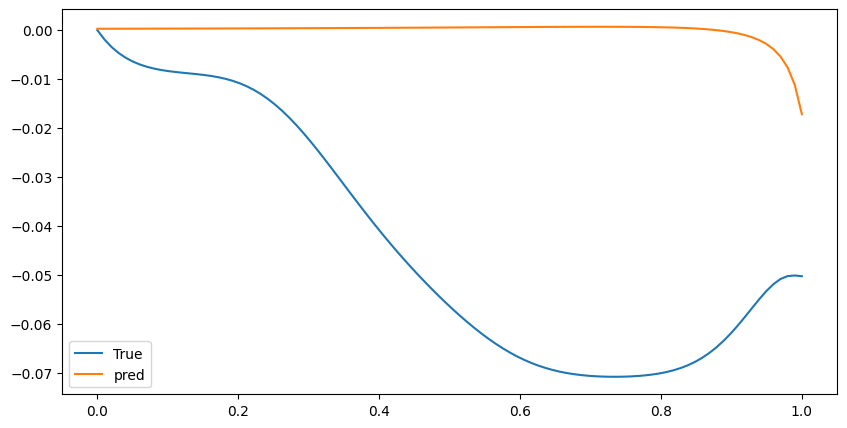

tensor(1.03019257482877124588, dtype=torch.float64, grad_fn=<DivBackward0>)


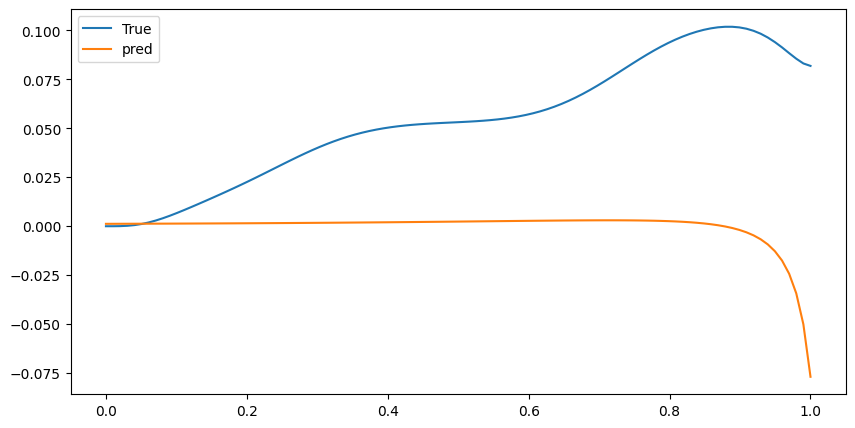

tensor(0.98091097003386107378, dtype=torch.float64, grad_fn=<DivBackward0>)


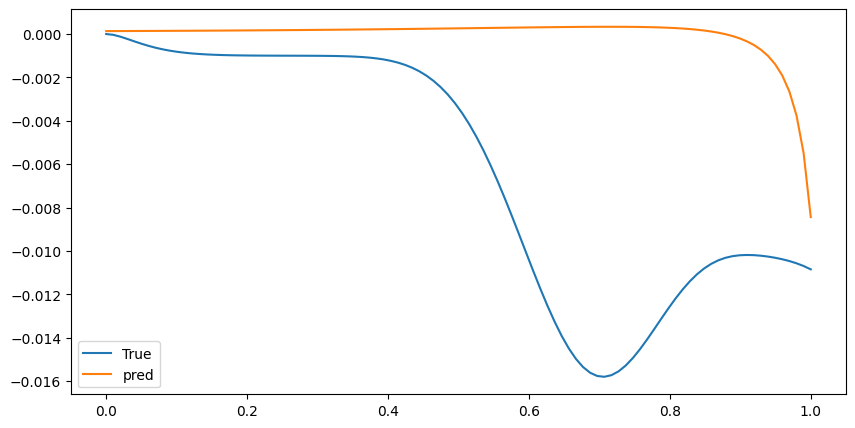

tensor(1.15034910787374888841, dtype=torch.float64, grad_fn=<DivBackward0>)


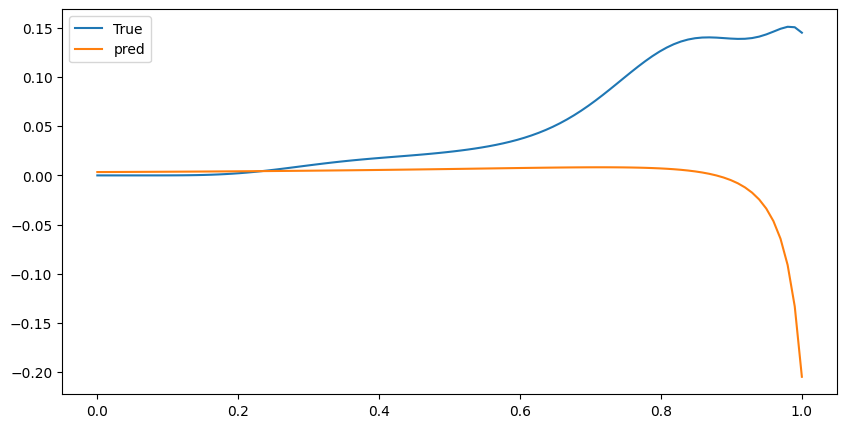

In [87]:
model.eval()
for d in data_test:
    input = d[:, :-1, :].to(device)
    input = eval_poly(input,x)
    input = input-input[:,:,0].unsqueeze(-1)
    coeffs = model(input)
    pred = eval_poly(coeffs, x)

    for i in range(len(pred[:, -1, :])):
        p = pred[i, -1, :]

        # Extract the coefficients
        o = d[i, -1, :].to(device)
        o = o.unsqueeze(0).unsqueeze(0)
        o_eval = eval_poly(o, x)

        o_eval = o_eval-o_eval[:,:,0]
        o_eval = o_eval.squeeze()

        dist, k = distanceProj(o_eval,p)
        p = k*p
        print(dist)

        plt.figure(figsize=(10,5))
        plt.plot(x, o_eval.detach().cpu().numpy(), label="True")
        plt.plot(x, p.detach().cpu().numpy(), label="pred")
        plt.legend()
        plt.show()
    break










Log model to Comet

In [88]:
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
experiment.log_model("model", model_path)
experiment.log_dataset_hash(data_train)
experiment.end()